In [31]:
import geopandas as gpd
import os
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import contextily as ctx
import pandas as pd

In [2]:
engine = create_engine(   
"mssql+pyodbc:///?odbc_connect="
"Driver%3D%7BODBC+Driver+17+for+SQL+Server%7D%3B"
"Server%3Drliddb.int.lcog.org%2C5433%3B"
"Database%3DRLIDGeo%3B"
"Trusted_Connection%3Dyes%3B"
"ApplicationIntent%3DReadWrite%3B"
"WSID%3Dclwrk4087.int.lcog.org%3B")

In [3]:
sql = '''
SELECT 
OBJECTID AS id,
rlidname AS name,
speed,
Shape.STAsBinary() AS geom
FROM dbo.Road;
'''

In [4]:
road = gpd.GeoDataFrame.from_postgis(sql, engine, geom_col='geom')

In [5]:
road.crs = "EPSG:2914"

In [6]:
road = road.to_crs(epsg=3857)

In [7]:
MPObd = gpd.read_file("X:/Data/Transportation/MPO_Bound.shp")

In [8]:
road_cl = gpd.clip(road, MPObd)

In [33]:
outpath = r'T:\DCProjects\Modeling\AADBT\input'

In [9]:
bike_counts_loc = gpd.read_file(outpath + '\shp\BikeCountsLocations.shp')

In [10]:
bike_counts_loc = bike_counts_loc.to_crs(epsg=3857)

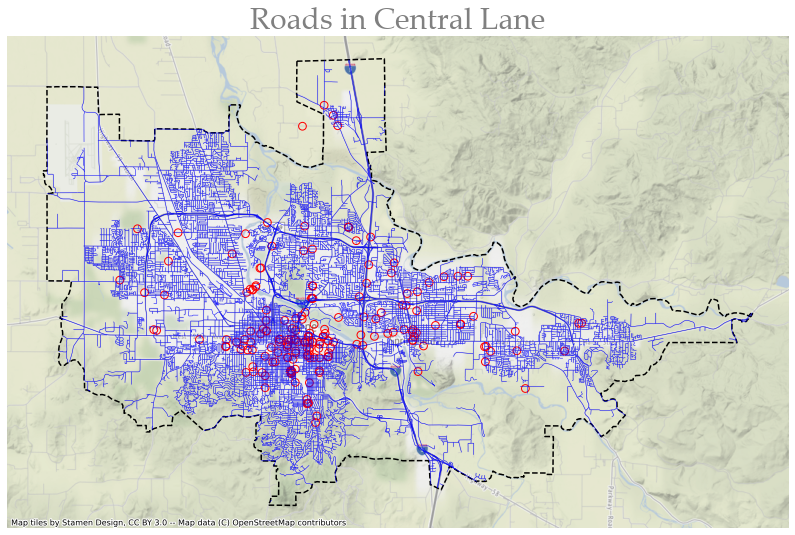

In [11]:
fig, ax = plt.subplots(figsize=(14, 12))
road_cl.plot(ax=ax, color='blue', linewidth = 0.5, aspect=1)
bike_counts_loc.plot(ax=ax, marker ='o', facecolor="none", edgecolor="red", markersize=60, aspect=1)
MPObd.plot(ax=ax, facecolor="none", edgecolor="black", linestyle='--', linewidth = 1.5, aspect=1)
ctx.add_basemap(ax, alpha = 0.7)
plt.title("Roads in Central Lane", fontsize=30, fontname="Palatino Linotype", 
          color="grey")
ax.axis("off");

In [12]:
bikecountloc_near_road = gpd.sjoin_nearest(bike_counts_loc, road_cl, distance_col="distances", how="left")

In [13]:
bikecountloc_near_road.head(2)

,Location,geometry,index_right,id,name,speed,distances
0,EastAmazonSouth39th,POINT (-13700851.461 5467390.544),9579,9589,E Amazon Dr,35.0,1.981160
1,KincaidSouth37th,POINT (-13700769.864 5467802.900),6194,6198,Kincaid St,20.0,2.105781


In [14]:
bikecountloc_near_road.speed.isna().sum()

4

In [16]:
type(bikecountloc_near_road)

geopandas.geodataframe.GeoDataFrame

In [15]:
bikecountloc_near_road[bikecountloc_near_road.speed.isna()]

,Location,geometry,index_right,id,name,speed,distances
7,ClearwaterPath,POINT (-13687569.837 5469544.464),19882,19958,Clearwater Ln,NaN,126.649055
73,MillracePathBoothKelly,POINT (-13694019.679 5472237.513),6106,6110,,NaN,96.221737
113,DStBoatRamp,POINT (-13697124.934 5472844.148),16553,16596,,NaN,20.321568
184,GatewayBPBridgeEastI5,POINT (-13697480.488 5477379.134),1334,1337,,NaN,17.927055


In [24]:
ids = bikecountloc_near_road[bikecountloc_near_road.speed.isna()].id.values

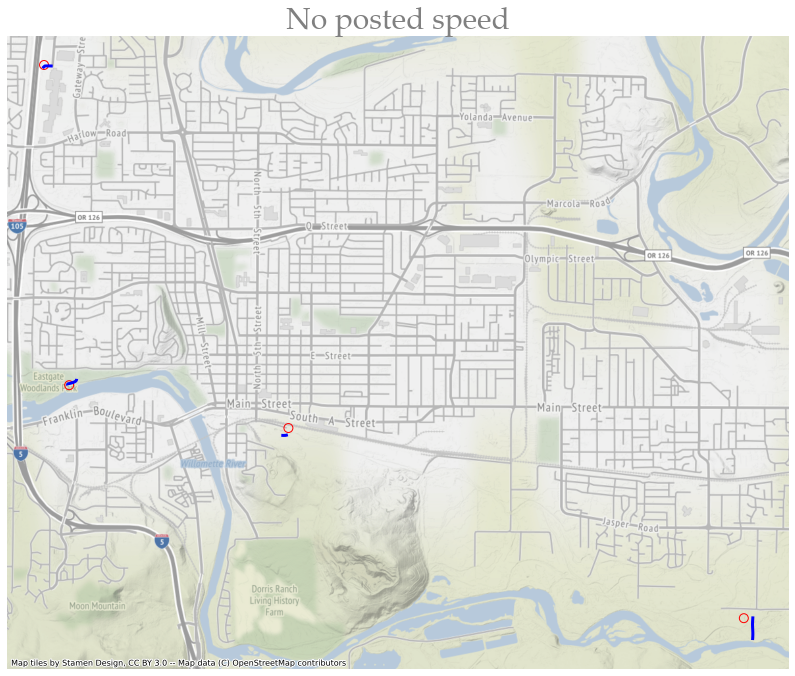

In [27]:
fig, ax = plt.subplots(figsize=(14, 12))
bikecountloc_near_road[bikecountloc_near_road.speed.isna()].plot(ax=ax, marker ='o', facecolor="none", edgecolor="red", markersize=80, aspect=1)
road_cl[road_cl.id.isin(ids)].plot(ax=ax, color='blue', linewidth = 3, aspect=1)
ctx.add_basemap(ax, alpha = 0.7)
plt.title("No posted speed", fontsize=30, fontname="Palatino Linotype", 
          color="grey")
ax.axis("off");

In [28]:
bikecountloc_near_road.loc[bikecountloc_near_road.speed.isna(), 'speed'] = 15

In [24]:
bikecountloc_near_road.distances.describe()

count     205.000000
mean       23.968673
std       113.157801
min         0.440453
25%         1.527283
50%         2.374598
75%         5.657515
max      1531.285911
Name: distances, dtype: float64

In [38]:
bikecountloc_near_road[bikecountloc_near_road.distances <= 20][['speed', 'distances']].describe()

,speed,distances
count,162.000000,163.000000
mean,27.006173,2.680982
std,6.141698,3.187861
min,5.000000,0.440453
25%,25.000000,1.509196
50%,25.000000,1.928842
75%,30.000000,2.409349
max,60.000000,17.961328


In [29]:
bikecountloc_near_road.loc[(bikecountloc_near_road.distances > 20) & (bikecountloc_near_road.speed > 25), 'speed'] = 25

In [32]:
df = pd.DataFrame(bikecountloc_near_road.drop(columns='geometry'))

In [36]:
df.to_csv(outpath + '\\roadway_speed.csv', index=False)

In [37]:
data = pd.read_csv(outpath+'\\Daily_Bike_Counts_With_VarData_ACS.csv')

In [38]:
df.rename(columns={"speed": "Speed"}, inplace=True)

In [40]:
data = data.merge(df[['Location', 'Speed']], on='Location')

In [41]:
data.to_csv(outpath + '\\Daily_Bike_Counts_With_AllVarData.csv', index=False)